In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os

def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    if frequency == "545":
        original_healpix_map = original_healpix_map/58.0356
    if frequency == "857":
        original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title="Full Sky CMB",
            unit=r"$μ$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

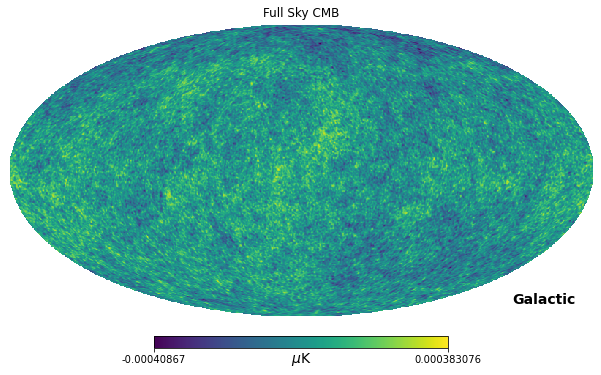

In [2]:

filename_template = ["febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization}.fits",
"COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits",
"ffp10_noise_{frequency}_full_map_mc_{realization}.fits"] 
directory = 'CMB_realizations'
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]  # Example frequencies


L= read_healpix_map("CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits", "100", plot = True).shape[0]

In [4]:
def read_healpix_map(CMB_map_path, frequency, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    if frequency == "545":
        original_healpix_map = original_healpix_map/58.0356
    if frequency == "857":
        original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title="Full Sky CMB",
            unit=r"$μ$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

def process_map(map_data, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Args:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    alm = hp.map2alm(map_data, lmax=lmax)
    processed_map = hp.alm2map(alm, nside=nside)
    return processed_map

def save_map(map_data, map_type, frequency, lmax, realization):
    """
    Saves the processed map to a file with a specific naming convention.
    
    Args:
        map_data (numpy.ndarray): Map data to be saved.
        map_type (str): Type of the map (e.g., "CMB", "Synchrotron", "Noise", "CSN").
        frequency (str): Frequency identifier.
        lmax (int): Maximum multipole moment used in processing.
        realization (str): Realization identifier.
    """
    filename = f"CMB_total/{map_type}_HP_Map_F{frequency}_L{lmax}_R{realization}.fits"
    hp.mollview(map_data, coord=["G"], title=f"{map_type} Map", unit=r"$μ$K")
    plot
    # hp.write_map(filename, map_data,dtype="float64")
    print(f"Map saved to {filename}")

def process_and_save_all_maps(frequencies, realizations, lmax, directory="CMB_realizations"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    for frequency in frequencies:
        for realization in realizations:
            
            path = f"CMB_total/CSN_HP_Map_F{frequency}_L{lmax}_R{realization:04d}.fits"
            if os.path.exists(path):
                print(f"File {path} already exists. Skipping download.")
                
                
                continue
                
            print(f"Processing maps for frequency {frequency} and realization {realization}")
            
            # Define file paths
            cmb_file = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
            synchrotron_file = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
            noise_file = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
            
            # Read maps
            cmb = read_healpix_map(cmb_file, frequency)
            synchrotron = read_healpix_map(synchrotron_file, frequency)
            noise = read_healpix_map(noise_file, frequency)
            
            # Calculate nside based on lmax
            nside = lmax // 2
            
            # Process maps
            new_cmb = process_map(cmb, lmax, nside)
            new_synchrotron = process_map(synchrotron, lmax, nside)
            new_noise = process_map(noise, lmax, nside)
            
            # Save processed maps
            save_map(new_cmb, "CMB", frequency, lmax, f"{realization:04d}")
            save_map(new_synchrotron, "Synchrotron", frequency, lmax, f"{realization:04d}")
            save_map(new_noise, "Noise", frequency, lmax, f"{realization:05d}")
            
            # Combine and save the total map
            csn = new_cmb + new_synchrotron + new_noise
            save_map(csn, "CSN", frequency, lmax, f"{realization:04d}")

# Define frequencies and realizations
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
realizations = list(range(10))  # Realizations from 0 to 9

# Example usage with user-defined lmax
process_and_save_all_maps(frequencies, realizations, lmax=32)


File CMB_total/CSN_HP_Map_F030_L32_R0000.fits already exists. Skipping download.
Processing maps for frequency 030 and realization 1
Map saved to CMB_total/CMB_HP_Map_F030_L32_R0001.fits
Map saved to CMB_total/Synchrotron_HP_Map_F030_L32_R0001.fits
Map saved to CMB_total/Noise_HP_Map_F030_L32_R00001.fits
Map saved to CMB_total/CSN_HP_Map_F030_L32_R0001.fits
Processing maps for frequency 030 and realization 2
Map saved to CMB_total/CMB_HP_Map_F030_L32_R0002.fits
Map saved to CMB_total/Synchrotron_HP_Map_F030_L32_R0002.fits
Map saved to CMB_total/Noise_HP_Map_F030_L32_R00002.fits
Map saved to CMB_total/CSN_HP_Map_F030_L32_R0002.fits
Processing maps for frequency 030 and realization 3
Map saved to CMB_total/CMB_HP_Map_F030_L32_R0003.fits
Map saved to CMB_total/Synchrotron_HP_Map_F030_L32_R0003.fits
Map saved to CMB_total/Noise_HP_Map_F030_L32_R00003.fits
Map saved to CMB_total/CSN_HP_Map_F030_L32_R0003.fits
Processing maps for frequency 030 and realization 4
Map saved to CMB_total/CMB_HP_

In [16]:
from astropy.io import fits
hfi = fits.open("/home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits")
# /home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits

In [19]:
print(hfi.info())

print(hfi[1].header)    

Filename: /home/max/CMB_plot/code/CMB_realizations/febecop_ffp10_lensed_scl_cmb_030_mc_0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  FULL SKY MAP    1 BinTableHDU     55   12288R x 3C   [1024E, 1024E, 1024E]   
None
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                12288 / width of table in bytes                        NAXIS2  =                12288 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                    3 / number of fields in each row                   COMMENT                                                       